# Preparación de datos.
## Caracterización de variables

In [221]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Escalado de features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

# Pipelinessss
from sklearn.pipeline import Pipeline

# Libraries to plot
import seaborn as sns

#Import the metrics class
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error


# Import to balance data
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Datasets.

In [2]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [222]:
df = pd.read_csv(DATASET_PATH+"/PS_20174392719_1491204439457_log.csv")

In [223]:
#Exploring the features availables in the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [224]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


### Statiscal information about variables

In [225]:
df.describe().round()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0
mean,243.0,179862.0,833883.0,855114.0,1100702.0,1224996.0,0.0,0.0
std,142.0,603858.0,2888243.0,2924049.0,3399180.0,3674129.0,0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,156.0,13390.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,239.0,74872.0,14208.0,0.0,132706.0,214661.0,0.0,0.0
75%,335.0,208721.0,107315.0,144258.0,943037.0,1111909.0,0.0,0.0
max,743.0,92445517.0,59585040.0,49585040.0,356015889.0,356179279.0,1.0,1.0


In [226]:
print('El porcentaje de casos de fraude es % \n', (df['isFraud'].value_counts()[1]/len(df)*100).round(4))

print(round(df.amount[df.isFraud ==0].describe()),2)

El porcentaje de casos de fraude es % 
 0.1291
count     6354407.0
mean       178197.0
std        596237.0
min             0.0
25%         13368.0
50%         74685.0
75%        208365.0
max      92445517.0
Name: amount, dtype: float64 2


In [227]:
print('El porcentaje de casos de NO fraude es % \n', (df['isFraud'].value_counts()[0]/len(df)*100).round(4))

print(round(df.amount[df.isFraud ==1].describe()),2)

El porcentaje de casos de NO fraude es % 
 99.8709
count        8213.0
mean      1467967.0
std       2404253.0
min             0.0
25%        127091.0
50%        441423.0
75%       1517771.0
max      10000000.0
Name: amount, dtype: float64 2


## Preparación de datos

A continuación se hace un análisis de los datos y preparación de variables. Se buscan los datos faltantes y se eliminan aquellas variables que no se consideran relevantes para el entrenamiento y evaluación del sistema.

Funcion de utilería para mostrar distribuciones.

In [228]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

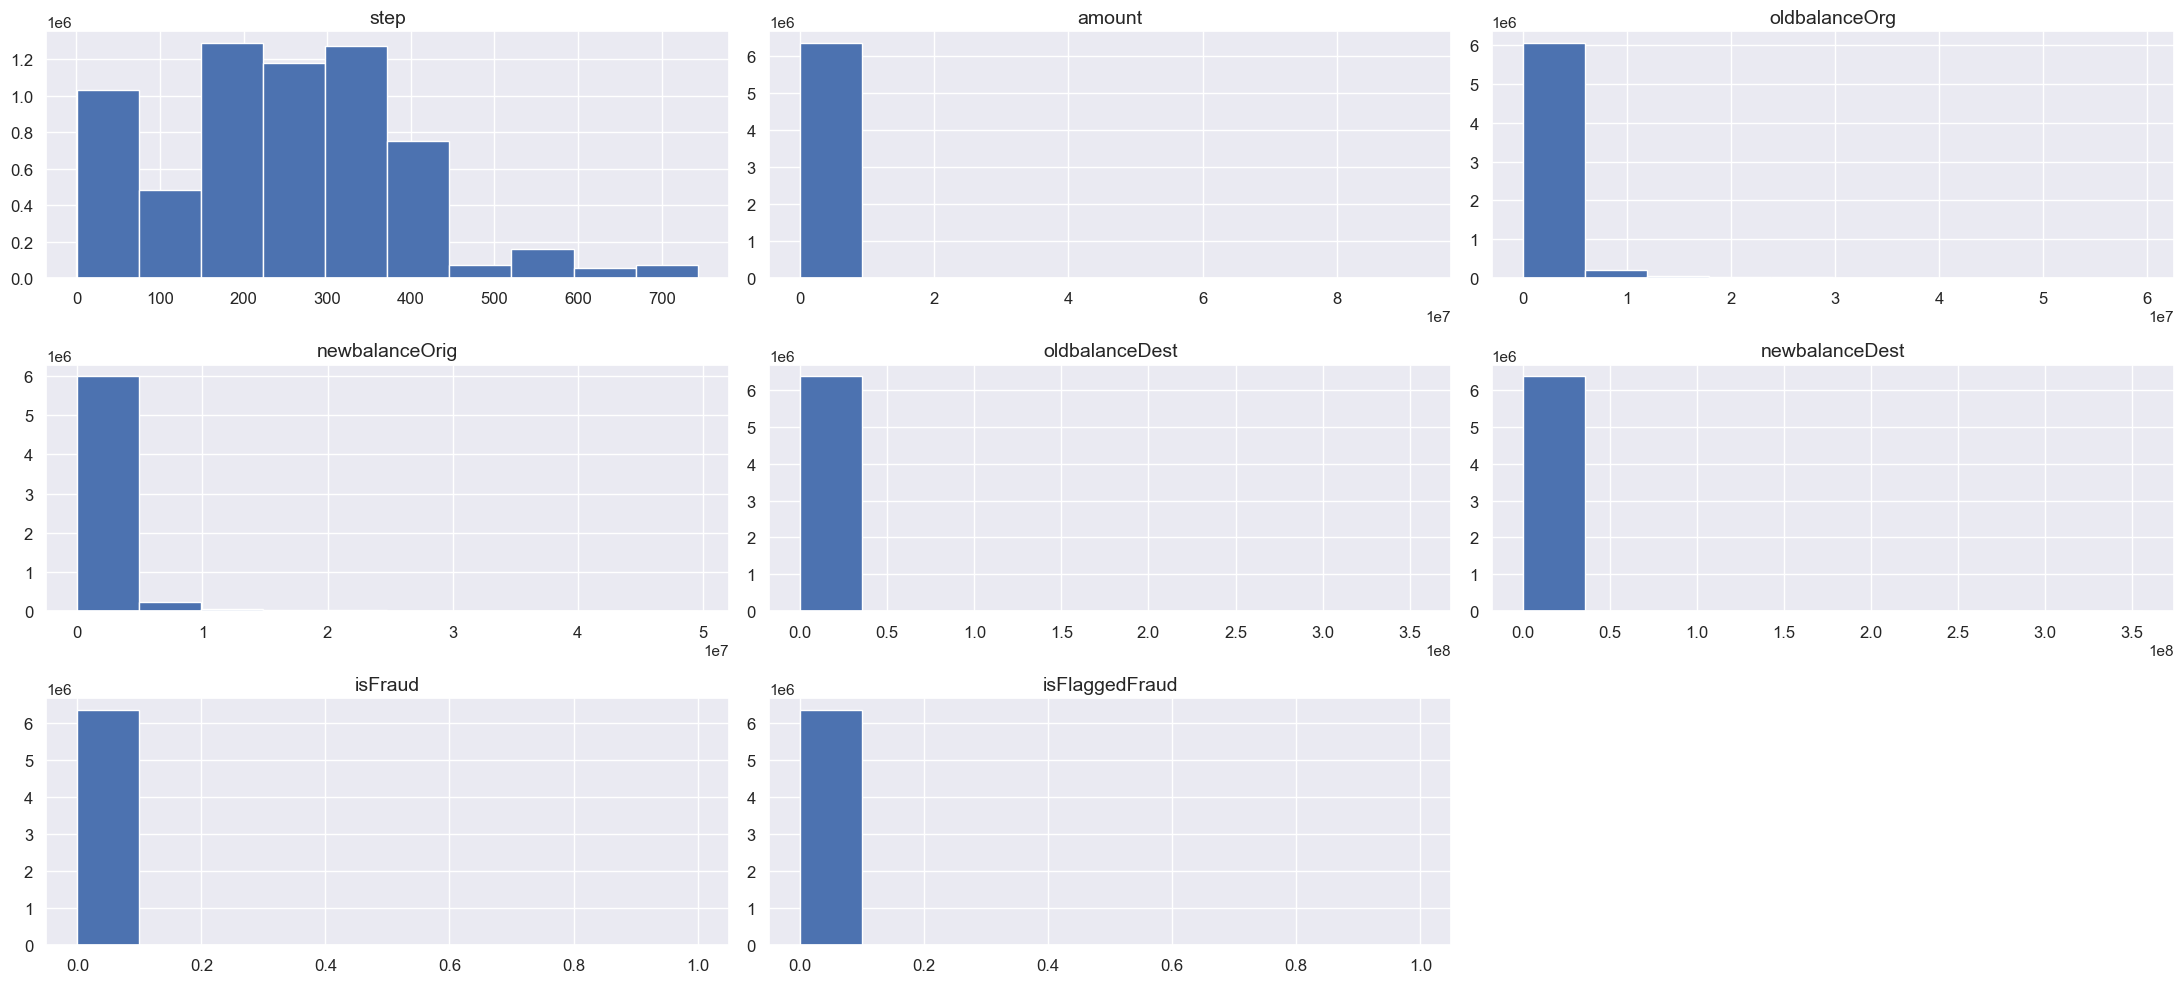

In [229]:
display_dataset_distributions(df)

## 2. Caracterización de variables

#### 2.1 Datos faltantes

In [230]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [231]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [232]:
df_modified = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_modified.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.0,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.0,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.0,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.0,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.0,0.00,0
5,PAYMENT,7817.71,53860.00,46042.29,0.0,0.00,0
6,PAYMENT,7107.77,183195.00,176087.23,0.0,0.00,0
7,PAYMENT,7861.64,176087.23,168225.59,0.0,0.00,0
8,PAYMENT,4024.36,2671.00,0.00,0.0,0.00,0
9,DEBIT,5337.77,41720.00,36382.23,41898.0,40348.79,0


In [233]:
df_modified_dummy = pd.get_dummies(data=df_modified, prefix='type', prefix_sep='.', drop_first=True)
df_modified_dummy.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type.CASH_OUT,type.DEBIT,type.PAYMENT,type.TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,True,False
1,1864.28,21249.0,19384.72,0.0,0.0,0,False,False,True,False
2,181.00,181.0,0.00,0.0,0.0,1,False,False,False,True
3,181.00,181.0,0.00,21182.0,0.0,1,True,False,False,False
4,11668.14,41554.0,29885.86,0.0,0.0,0,False,False,True,False


In [234]:
df_modified_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   amount          float64
 1   oldbalanceOrg   float64
 2   newbalanceOrig  float64
 3   oldbalanceDest  float64
 4   newbalanceDest  float64
 5   isFraud         int64  
 6   type.CASH_OUT   bool   
 7   type.DEBIT      bool   
 8   type.PAYMENT    bool   
 9   type.TRANSFER   bool   
dtypes: bool(4), float64(5), int64(1)
memory usage: 315.5 MB


Separación en train set y test set

In [235]:
train_ratio = 0.7
test_ratio = 0.3
use_cols = ['amount', 'oldbalanceOrg',	'newbalanceOrig','oldbalanceDest', 	'newbalanceDest']
X_train, X_test, y_train, y_test = train_test_split(
    #df[use_cols], 
    df_modified_dummy.drop(['isFraud'], axis=1),
    df_modified_dummy['isFraud'],
    stratify= df_modified_dummy['isFraud'],  
    train_size=train_ratio,
    test_size=test_ratio,
    random_state=1)

X_train.shape, X_test.shape

((4453834, 9), (1908786, 9))

In [236]:
X_train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type.CASH_OUT,type.DEBIT,type.PAYMENT,type.TRANSFER
3000389,186408.67,47612.00,0.00,693886.60,880295.27,True,False,False,False
1491891,28407.76,11467.00,0.00,0.00,0.00,False,False,True,False
634967,19224.39,2677199.19,2696423.58,57778.53,38554.14,False,False,False,False
3971909,23822.08,0.00,0.00,0.00,0.00,False,False,True,False
2144333,5610.43,9905.00,4294.57,0.00,0.00,False,False,True,False


### Escalado de datos

In [251]:
scaler = StandardScaler()
#ct = ColumnTransformer([('X_train_scaled', scaler, ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest'])], remainder='passthrough')

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =  scaler.transform(X_test)

### Training the model

En esta sección se hace un entrenamiento del modelo de los datos sin balancerar.

In [253]:
lregression = LogisticRegression()

In [254]:
lregression.fit(X_train_scaled, y_train)

c:\Users\fSIoF\Documents\IA\ApMaI\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [240]:
### Model predict
y_pred = lregression.predict(X_test_scaled)

In [241]:
y_pred.shape

(1908786,)

### Metrics

In [242]:
cnf_matrix =  metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1906234,      88],
       [   1481,     983]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted')

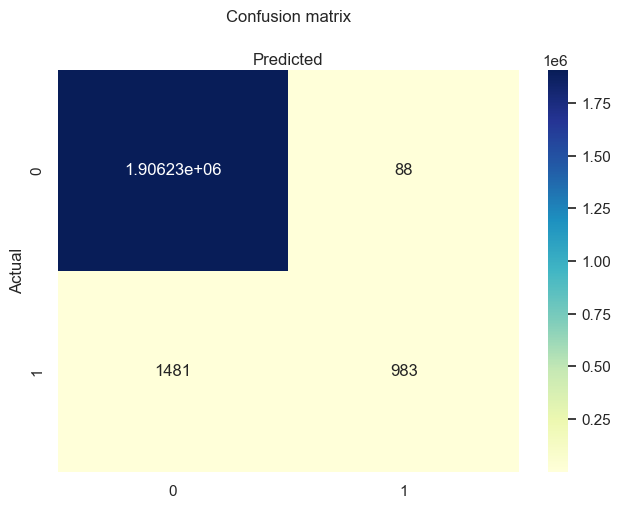

In [243]:
### Confusion matrix visualization with heatmap

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#Text(0.5, 257.44, 'Predicted')

### Evalauation metrics

In [244]:
target_names = ['No fraud', 'Fraud']
print(classification_report(y_test, y_pred,  target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      1.00      1.00   1906322
       Fraud       0.92      0.40      0.56      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.70      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786



Se encontró que al evaluar el modelo con regresión logística sin el balanceo de datos se obtuvo una precisión alta para los casos de **No fraud**, **fraud**.

In [245]:
#Creo el objeto decision_tree
decision_Tree = DecisionTreeClassifier()

In [246]:
decision_Tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [247]:
target_names = ['No fraud', 'Fraud']
decision_Tree_pred = decision_Tree.predict(X_test_scaled)
print(classification_report(y_test, decision_Tree_pred, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      1.00      1.00   1906322
       Fraud       0.90      0.89      0.90      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.95      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



## Balanceo de datos

### Random Over Sampling

In [255]:
ros_method = RandomOverSampler(sampling_strategy="minority" )
#Apply resampling to the training data only
X_resampled, y_resampled = ros_method.fit_resample(X_train_scaled, y_train)


##### Logistic regression for ROS

In [256]:
lregression_ros = LogisticRegression()
lregression_ros.fit(X_resampled, y_resampled)

c:\Users\fSIoF\Documents\IA\ApMaI\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [257]:
# Testing the model
target_names = ['No fraud', 'Fraud']
predicted_ros = lregression_ros.predict(X_test_scaled)
print(classification_report(y_test, predicted_ros))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



### Class weighting

In [258]:
class_weight = LogisticRegression(class_weight='balanced')
class_weight.fit(X_train_scaled, y_train)

c:\Users\fSIoF\Documents\IA\ApMaI\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [259]:
target_names = ['No fraud', 'Fraud']
predicted_class_weight = class_weight.predict(X_test_scaled)
proba_class_weight = class_weight.predict_proba(X_test_scaled)
print(classification_report(y_test, predicted_class_weight, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      0.95      0.97   1906322
       Fraud       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [260]:
cfmatrix =   metrics.confusion_matrix(y_test, predicted_class_weight)
cfmatrix

array([[1805846,  100476],
       [    156,    2308]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted')

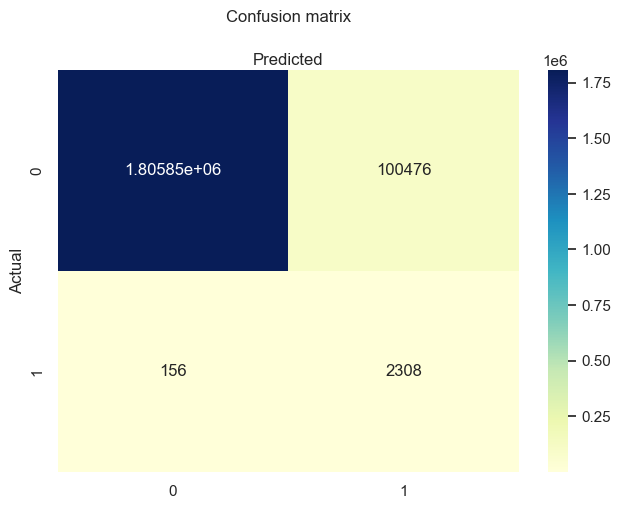

In [261]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cfmatrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [262]:
precision, recall, threshold=precision_recall_curve(y_test, proba_class_weight[:,1])
print('Area bajo la curva ROC:', roc_auc_score(y_test, proba_class_weight[:,1]))
print('Area bajo la curva Precision-Recall:', auc(recall, precision))

Area bajo la curva ROC: 0.9890773568797682
Area bajo la curva Precision-Recall: 0.5611298305702955


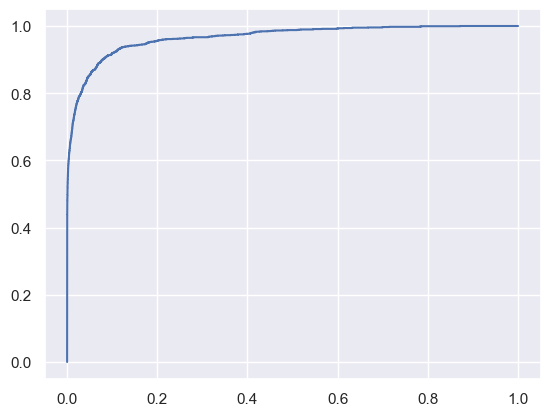

In [38]:
fpr, tpr, _ = metrics.roc_curve(y_test, proba_class_weight[:,1])
plt.plot(fpr, tpr)

### SMOTE

In [263]:
smote_method = SMOTE(random_state=1)
#Apply resampling to the training data only
X_resampled_smote, y_resampled_smote = smote_method.fit_resample(X_train_scaled, y_train)

##### Logistic regression for SMOTE

In [264]:
lregression_smote = LogisticRegression()
lregression_smote.fit(X_resampled_smote, y_resampled_smote)

c:\Users\fSIoF\Documents\IA\ApMaI\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [265]:
#Testing the model
target_names = ['No fraud', 'Fraud']
predicted_smote = lregression_smote.predict(X_test_scaled)
print(classification_report(y_test, predicted_smote, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      0.95      0.97   1906322
       Fraud       0.02      0.95      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



## Decision tree

In [266]:
target_names = ['No fraud', 'Fraud']
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

#### Metrics

In [267]:
target_names = ['No fraud', 'Fraud']
decisionTree_predict = decisionTree.predict(X_test_scaled)
print(classification_report(y_test, decisionTree_predict, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      1.00      1.00   1906322
       Fraud       0.89      0.86      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.94      0.93      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



## Random Forest

In [268]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [269]:
rf_predict = rf.predict(X_test_scaled)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



### RF with ROS 

In [270]:
rf_ros = RandomForestClassifier()
rf_ros.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [271]:
rf_predict_ros = rf_ros.predict(X_test_scaled)
print(classification_report(y_test, rf_predict_ros))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.92      0.82      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.91      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



### RF with resample smote

In [272]:
rf_smote = RandomForestClassifier()
rf_smote.fit(X_resampled_smote, y_resampled_smote)

In [17]:
rf_predict_smote = rf_smote.predict(X_test_scaled)
print(classification_report(y_test, rf_predict_smote))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270877
           1       0.11      0.75      0.18      1647

    accuracy                           0.99   1272524
   macro avg       0.55      0.87      0.59   1272524
weighted avg       1.00      0.99      0.99   1272524

